# Create a dataset of faces dividing them in fake and real

### Libraries, constants and pre-trained MTCNN

Install FaceNet-PyTorch if it's not already installed (it includes the pre-trained MTCNN model):

In [25]:
%%capture
!pip install facenet-pytorch Pillow pandas tqdm

Import the necessary libraries:

In [26]:
import numpy as np
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import os 
import cv2
from random import randint
from PIL import Image
from tqdm import tqdm

In [27]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


Import the pre-trained MTCNN:

[Guide on how to use MTCNN](https://www.kaggle.com/code/timesler/guide-to-mtcnn-in-facenet-pytorch/notebook)

In [28]:
from facenet_pytorch import MTCNN

Constants:

In [29]:
from constants import ORIGINAL_VIDEOS_FOLDER, FAKE_VIDEOS_FOLDER, FACES_FOLDER, FACES_REAL, FACES_FAKE

Lists of fake and real videos:

In [30]:
ORIGINAL_VIDEOS = os.listdir(ORIGINAL_VIDEOS_FOLDER)
FAKE_VIDEOS = os.listdir(FAKE_VIDEOS_FOLDER)

### Plot some examples

post_process avoids image normalization to be able to plot the images:

In [31]:
# Load the MTCNN in evaluation mode
# -> Evaluation deactivates Dropout layers, which speeds up the inference
mtcnn = MTCNN(select_largest=False, post_process=False, device=device).eval()

In [32]:
def plot_example(num_samples=3):
    """Plot the first frame of fake video and the extracted face"""
    _, ax = plt.subplots(nrows=num_samples, ncols=2, figsize=(18, 10))
    
    for i in range(num_samples):
        video_idx = randint(0, len(FAKE_VIDEOS)-1)

        # Fake video
        fake_video = cv2.VideoCapture(
            os.path.join(FAKE_VIDEOS_FOLDER, FAKE_VIDEOS[video_idx]
        ))
        # Get the first frame
        _, fake_frame = fake_video.read()
        # BGR -> RGB
        fake_frame = cv2.cvtColor(fake_frame, cv2.COLOR_BGR2RGB)

        # Convert the image (numpy array) to a Pillow Image
        frame = Image.fromarray(fake_frame)
        face = mtcnn(frame)

        # After being processed by MTCNN, the face has the shape: (CHANNELS, HEIGHT, WIDTH)
        # we have to change the change so that it has the shape (HEIGHT, WIDTH, CHANNELS)
        face = face.permute(1, 2, 0)

        # Remember that the output of the model is a tensor where the pixel values are float values
        # To be able to plot the face, we have to convert it into a numpy array of integer values
        #
        # If the image is in the GPU, we also have to move it to the CPU
        face = face.cpu().detach().int().numpy()

        # Plot the frames
        ax[i, 0].imshow(fake_frame)
        ax[i, 1].imshow(face)
        ax[i, 0].set_title("Fake (full image)")
        ax[i, 1].set_title("Fake (face)")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

/home/espasa/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


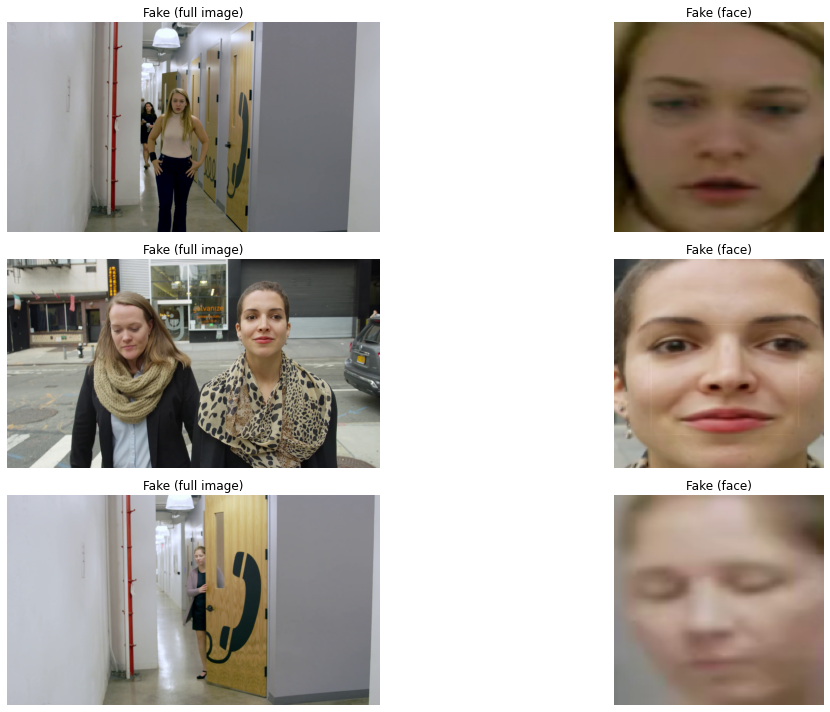

In [33]:
plot_example()

In [35]:
examples_folder = "../examples/"

for i in range(1, 21):
    video_idx = randint(0, len(FAKE_VIDEOS)-1)
    fake_video = cv2.VideoCapture(
        os.path.join(FAKE_VIDEOS_FOLDER, FAKE_VIDEOS[video_idx]
    ))
    _, fake_frame = fake_video.read()
    fake_frame = cv2.cvtColor(fake_frame, cv2.COLOR_BGR2RGB)
    Image.fromarray(fake_frame).save(os.path.join(examples_folder, f'fake_frame_{i}.png'))

for i in range(1, 21):
    video_idx = randint(0, len(ORIGINAL_VIDEOS)-1)
    real_video = cv2.VideoCapture(
        os.path.join(ORIGINAL_VIDEOS_FOLDER, ORIGINAL_VIDEOS[video_idx]
    ))
    _, real_frame = real_video.read()
    real_frame = cv2.cvtColor(real_frame, cv2.COLOR_BGR2RGB)
    Image.fromarray(real_frame).save(os.path.join(examples_folder, f'real_frame_{i}.png'))

### Create the new dataset

Create a new folder where we'll store the face images:

In [10]:
!rm -rf ../data/faces/real

In [11]:
!rm -rf ../data/faces

In [12]:
os.mkdir(FACES_FOLDER)
os.mkdir(FACES_REAL)
os.mkdir(FACES_FAKE)

In [13]:
!ls ../data/faces

fake  real


Function to store the face images:

In [14]:
def get_face_name_from_video_name(video_name):
    """Get the face name from the video name"""
    img_name = video_name.split(".mp4")[0] # Remove the .mp4 extension
    return img_name + "_face.png" # Add the _face.png extension

In [15]:
def save_frame(fake_frame, video_name, faces_folder):
    fake_frame = cv2.cvtColor(fake_frame, cv2.COLOR_BGR2RGB) # BGR -> RGB

    frame = Image.fromarray(fake_frame)
    face = mtcnn(frame) # extract the face from the frame

    # if the face is not found on the image, we do not save it
    if face is None: return

    # (CHANNELS, HEIGHT, WIDTH) -> (HEIGHT, WIDTH, CHANNELS)
    face = face.permute(1, 2, 0)
    # face is a tensor where the pixel values are float32 values
    # -> move it to the CPU, convert it to int values and then to a numpy array 
    face = face.cpu().detach().numpy().astype(np.uint8)

    # Save the face
    img_name = get_face_name_from_video_name(video_name)
    Image.fromarray(face).save(os.path.join(faces_folder, img_name))

In [19]:
def save_face(videos_folder, videos_names, faces_folder, is_real=None):
    """Save the face of the video in the faces_folder"""
    folder_tag = "real" if is_real else "fake"
    for i in tqdm(range(len(videos_names)), desc=f"Extracting faces from {folder_tag} folder"):
        fake_video = cv2.VideoCapture(
            os.path.join(videos_folder, videos_names[i]
        ))
        
        # a frame_skip of 60 frames, as each video has 30fps, it's 2 secods
        # fake videos are a little bit longer and there's more quantity, so the frame
        # skip has to be bigger
        frame_skip = 60 if is_real else 90
        
        count = 0
        frame_num = 0
        ret, real_frame = fake_video.read()
        while ret:
            # the name has to be different for each frame
            name_array = videos_names[i].split(".")
            name = f"{name_array[0]}_f{frame_num}.{name_array[1]}"
            save_frame(real_frame, name, faces_folder)

            frame_num += 1
            count += frame_skip
            fake_video.set(cv2.CAP_PROP_POS_FRAMES, count)
            ret, real_frame = fake_video.read()

In [20]:
# Store the faces of the real videos:
save_face(ORIGINAL_VIDEOS_FOLDER, ORIGINAL_VIDEOS, FACES_REAL, is_real=True)
# Store the faces of the fake videos:
save_face(FAKE_VIDEOS_FOLDER, FAKE_VIDEOS, FACES_FAKE, is_real=False)

Extracting faces from fake folder: 100%|██████████████████████████████████████████████████████████████████████████| 3068/3068 [2:35:47<00:00,  3.05s/it]


### Save the images names with their label as a csv file

In [21]:
real_faces = os.listdir(FACES_REAL)
real_faces = np.array(list(zip(real_faces, ["real"]*len(real_faces))))
fake_faces = os.listdir(FACES_FAKE)
fake_faces = np.array(list(zip(fake_faces, ["fake"]*len(fake_faces))))

faces = np.concatenate((real_faces, fake_faces))

# shuffle the data
np.random.shuffle(faces)

In [22]:
df = pd.DataFrame(faces, columns=["name", "label"])


In [23]:
df.head(30)

,name,label
0,07_09__kitchen_still__N9CWME71_f8_face.png,fake
1,27__outside_talking_still_laughing_f8_face.png,real
2,02__kitchen_still_f14_face.png,real
3,25_26__secret_conversation__GJT740J9_f0_face.png,fake
4,12_03__kitchen_pan__D7G6YJON_f7_face.png,fake
5,24__exit_phone_room_f5_face.png,real
6,01__meeting_serious_f6_face.png,real
7,14_03__kitchen_still__0O9TTCJT_f9_face.png,fake
8,12_15__kitchen_pan__RK17XFJ9_f4_face.png,fake
9,26_25__outside_talking_still_laughing__7ZRKCFM...,fake


In [24]:
df.to_csv(os.path.join(FACES_FOLDER, "faces.csv"))